In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

In [2]:
def format_model_name(key):
    if key == 'rnn':
        return 'RNN-SF'
    elif key == 'rnn_oja':
        return 'RNN-Oja'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [3]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [4]:
hue_order = [
    #'Linear',
    'RNN-SF',
    'MLP with Replay Buffer',
    'RNN-Oja',
    'Linear'
    #'RNN with Fixed LR', 'RNN with Dynamic LR',
    ]

# Collect aggregate metrics

In [72]:
# Collect measures of all iterations
root_dir = "/home/chingf/engram/Ching/03_td_discrete_corr/"

init_sparsities = []
final_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []
chance_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            print(path)
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    if not os.path.isfile(iter_path + 'results.p'):
                        continue
                    for file in os.listdir(iter_path):
                        print(file)
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        try:
                            scalar_events = event_acc.Scalars('loss_train')
                        except:
                            continue
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                        
                        init_sparsities.append(init_sparsity)
                        results = pickle.load(open(iter_path + 'results.p', 'rb'))
                        final_sparsities.append(results['dset'].feature_maker.post_smooth_sparsity)
                        sigmas.append(sigma)
                        gammas.append(gamma)
                        models.append(model)
                        start_losses.append(values[0])
                        time_to_elbows.append(steps[time_to_95])
                        #time_to_elbows.append(steps[np.argmax(central_diffs)])
                        final_losses.append(values[-1])
                        if 'mlp' in model_dir:
                            chance_losses.append(np.nan)
                        else:
                            chance_losses.append(event_acc.Scalars('chance_loss')[-1].value)
                        break

init_sparsities = np.array(init_sparsities)
final_sparsities = np.array(final_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)
chance_losses = np.array(chance_losses)

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157895/sigma1.0/0.8/
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157895/sigma1.0/0.6/
results.p
model.pt
events.out.tfevents.1641295471.mushroombody.aronov.zi.columbia.edu.34083.39
events.out.tfevents.1641295281.mushroombody.aronov.zi.columbia.edu.34083.37
results.p
model.pt
events.out.tfevents.1641295376.mushroombody.aronov.zi.columbia.edu.34083.38
events.out.tfevents.1641293482.mushroombody.aronov.zi.columbia.edu.34083.29
results.p
model.pt
events.out.tfevents.1641290123.mushroombody.aronov.zi.columbia.edu.34083.27
results.p
model.pt
events.out.tfevents.1641291793.mushroombody.aronov.zi.columbia.edu.34083.28
events.out.tfevents.1641295262.mushroombody.aronov.zi.columbia.edu.34083.36
results.p
model.pt
events.out.tfevents.1641295232.mushroombody.aronov.zi.columbia.edu.34083.34
results.p
model.pt
events.out.tfevents.1641295242.mushroombody.aronov.zi.columbia.edu.34083.35
events.out.tfevents.1641

results.p
model.pt
events.out.tfevents.1641286969.mushroombody.aronov.zi.columbia.edu.34132.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.09478947368421052/sigma1.0/0.8/
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.09478947368421052/sigma1.0/0.6/
results.p
model.pt
events.out.tfevents.1641309174.mushroombody.aronov.zi.columbia.edu.34102.59
results.p
events.out.tfevents.1641308983.mushroombody.aronov.zi.columbia.edu.34102.57
results.p
events.out.tfevents.1641309076.mushroombody.aronov.zi.columbia.edu.34102.58
results.p
events.out.tfevents.1641307268.mushroombody.aronov.zi.columbia.edu.34102.49
events.out.tfevents.1641303854.mushroombody.aronov.zi.columbia.edu.34102.47
results.p
model.pt
events.out.tfevents.1641305540.mushroombody.aronov.zi.columbia.edu.34102.48
results.p
model.pt
events.out.tfevents.1641308974.mushroombody.aronov.zi.columbia.edu.34102.56
results.p
model.pt
events.out.tfevents.1641308956.mushroombody.aronov.zi.columbia.edu.34102.54
results.p
model

events.out.tfevents.1641295181.mushroombody.aronov.zi.columbia.edu.34084.34
results.p
events.out.tfevents.1641295191.mushroombody.aronov.zi.columbia.edu.34084.35
events.out.tfevents.1641286564.mushroombody.aronov.zi.columbia.edu.34084.24
results.p
events.out.tfevents.1641283135.mushroombody.aronov.zi.columbia.edu.34084.22
results.p
model.pt
events.out.tfevents.1641284859.mushroombody.aronov.zi.columbia.edu.34084.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1266842105263158/sigma0.0/0.75/
results.p
model.pt
events.out.tfevents.1641280808.mushroombody.aronov.zi.columbia.edu.34082.19
results.p
model.pt
events.out.tfevents.1641280613.mushroombody.aronov.zi.columbia.edu.34082.17
results.p
model.pt
events.out.tfevents.1641280720.mushroombody.aronov.zi.columbia.edu.34082.18
results.p
model.pt
events.out.tfevents.1641277619.mushroombody.aronov.zi.columbia.edu.34082.9
results.p
events.out.tfevents.1641271438.mushroombody.aronov.zi.columbia.edu.34082.7
results.p
model.pt
events.out

results.p
model.pt
events.out.tfevents.1641280518.mushroombody.aronov.zi.columbia.edu.34107.16
results.p
model.pt
events.out.tfevents.1641280499.mushroombody.aronov.zi.columbia.edu.34107.14
events.out.tfevents.1641280508.mushroombody.aronov.zi.columbia.edu.34107.15
results.p
events.out.tfevents.1641264610.mushroombody.aronov.zi.columbia.edu.34107.4
events.out.tfevents.1641257950.mushroombody.aronov.zi.columbia.edu.34107.2
results.p
events.out.tfevents.1641261347.mushroombody.aronov.zi.columbia.edu.34107.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma3.0/0.6/
events.out.tfevents.1641313800.mushroombody.aronov.zi.columbia.edu.34077.47
results.p
events.out.tfevents.1641315454.mushroombody.aronov.zi.columbia.edu.34077.48
events.out.tfevents.1641310372.mushroombody.aronov.zi.columbia.edu.34077.44
results.p
model.pt
events.out.tfevents.1641306854.mushroombody.aronov.zi.columbia.edu.34077.42
results.p
model.pt
events.out.tfevents.1641308542.mushroombody.aron

results.p
model.pt
events.out.tfevents.1641281025.mushroombody.aronov.zi.columbia.edu.34083.15
events.out.tfevents.1641264991.mushroombody.aronov.zi.columbia.edu.34083.4
results.p
model.pt
events.out.tfevents.1641258058.mushroombody.aronov.zi.columbia.edu.34083.2
results.p
model.pt
events.out.tfevents.1641261583.mushroombody.aronov.zi.columbia.edu.34083.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.011421052631578946/sigma1.0/0.8/
events.out.tfevents.1641313615.mushroombody.aronov.zi.columbia.edu.34074.62
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.011421052631578946/sigma1.0/0.6/
results.p
events.out.tfevents.1641295458.mushroombody.aronov.zi.columbia.edu.34111.39
results.p
model.pt
events.out.tfevents.1641295258.mushroombody.aronov.zi.columbia.edu.34111.37
results.p
model.pt
events.out.tfevents.1641295366.mushroombody.aronov.zi.columbia.edu.34111.38
results.p
model.pt
events.out.tfevents.1641293482.mushroombody.aronov.zi.columbia.edu.34111.29
results.p
events.

events.out.tfevents.1641281165.mushroombody.aronov.zi.columbia.edu.34130.18
results.p
model.pt
events.out.tfevents.1641277969.mushroombody.aronov.zi.columbia.edu.34130.9
results.p
model.pt
events.out.tfevents.1641271759.mushroombody.aronov.zi.columbia.edu.34130.7
events.out.tfevents.1641275013.mushroombody.aronov.zi.columbia.edu.34130.8
results.p
events.out.tfevents.1641281053.mushroombody.aronov.zi.columbia.edu.34130.16
results.p
events.out.tfevents.1641281034.mushroombody.aronov.zi.columbia.edu.34130.14
results.p
model.pt
events.out.tfevents.1641281043.mushroombody.aronov.zi.columbia.edu.34130.15
results.p
model.pt
events.out.tfevents.1641264933.mushroombody.aronov.zi.columbia.edu.34130.4
results.p
model.pt
events.out.tfevents.1641258056.mushroombody.aronov.zi.columbia.edu.34130.2
results.p
model.pt
events.out.tfevents.1641261549.mushroombody.aronov.zi.columbia.edu.34130.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma3.0/0.6/
events.out.tfevents.164

events.out.tfevents.1641308946.mushroombody.aronov.zi.columbia.edu.36673.15
events.out.tfevents.1641300435.mushroombody.aronov.zi.columbia.edu.36673.4
results.p
model.pt
events.out.tfevents.1641297062.mushroombody.aronov.zi.columbia.edu.36673.2
results.p
events.out.tfevents.1641298760.mushroombody.aronov.zi.columbia.edu.36673.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.07915789473684211/sigma1.0/0.75/
results.p
events.out.tfevents.1641280979.mushroombody.aronov.zi.columbia.edu.34123.19
results.p
model.pt
events.out.tfevents.1641280760.mushroombody.aronov.zi.columbia.edu.34123.17
results.p
model.pt
events.out.tfevents.1641280870.mushroombody.aronov.zi.columbia.edu.34123.18
results.p
model.pt
events.out.tfevents.1641277722.mushroombody.aronov.zi.columbia.edu.34123.9
results.p
model.pt
events.out.tfevents.1641271543.mushroombody.aronov.zi.columbia.edu.34123.7
results.p
events.out.tfevents.1641274788.mushroombody.aronov.zi.columbia.edu.34123.8
results.p
events.out.tfevents.16

results.p
model.pt
events.out.tfevents.1641303719.mushroombody.aronov.zi.columbia.edu.34116.47
results.p
model.pt
events.out.tfevents.1641305428.mushroombody.aronov.zi.columbia.edu.34116.48
events.out.tfevents.1641308920.mushroombody.aronov.zi.columbia.edu.34116.56
results.p
model.pt
events.out.tfevents.1641308902.mushroombody.aronov.zi.columbia.edu.34116.54
results.p
model.pt
events.out.tfevents.1641308911.mushroombody.aronov.zi.columbia.edu.34116.55
results.p
model.pt
events.out.tfevents.1641300307.mushroombody.aronov.zi.columbia.edu.34116.44
results.p
model.pt
events.out.tfevents.1641296919.mushroombody.aronov.zi.columbia.edu.34116.42
results.p
events.out.tfevents.1641298631.mushroombody.aronov.zi.columbia.edu.34116.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06352631578947368/sigma1.0/0.75/
events.out.tfevents.1641280755.mushroombody.aronov.zi.columbia.edu.34100.19
results.p
events.out.tfevents.1641280542.mushroombody.aronov.zi.columbia.edu.34100.17
results.p
model.p

results.p
model.pt
events.out.tfevents.1641280664.mushroombody.aronov.zi.columbia.edu.34097.17
results.p
events.out.tfevents.1641280756.mushroombody.aronov.zi.columbia.edu.34097.18
results.p
events.out.tfevents.1641277640.mushroombody.aronov.zi.columbia.edu.34097.9
results.p
model.pt
events.out.tfevents.1641271462.mushroombody.aronov.zi.columbia.edu.34097.7
events.out.tfevents.1641274730.mushroombody.aronov.zi.columbia.edu.34097.8
results.p
model.pt
events.out.tfevents.1641280652.mushroombody.aronov.zi.columbia.edu.34097.16
results.p
events.out.tfevents.1641280618.mushroombody.aronov.zi.columbia.edu.34097.14
results.p
model.pt
events.out.tfevents.1641280635.mushroombody.aronov.zi.columbia.edu.34097.15
events.out.tfevents.1641264806.mushroombody.aronov.zi.columbia.edu.34097.4
results.p
events.out.tfevents.1641258032.mushroombody.aronov.zi.columbia.edu.34097.2
results.p
model.pt
events.out.tfevents.1641261479.mushroombody.aronov.zi.columbia.edu.34097.3
/home/chingf/engram/Ching/03_td_dis

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05336842105263158/sigma0.0/0.6/
results.p
model.pt
events.out.tfevents.1641295048.mushroombody.aronov.zi.columbia.edu.34086.39
results.p
events.out.tfevents.1641294868.mushroombody.aronov.zi.columbia.edu.34086.37
results.p
model.pt
events.out.tfevents.1641294956.mushroombody.aronov.zi.columbia.edu.34086.38
results.p
events.out.tfevents.1641293138.mushroombody.aronov.zi.columbia.edu.34086.29
results.p
model.pt
events.out.tfevents.1641289783.mushroombody.aronov.zi.columbia.edu.34086.27
events.out.tfevents.1641291446.mushroombody.aronov.zi.columbia.edu.34086.28
results.p
model.pt
events.out.tfevents.1641294859.mushroombody.aronov.zi.columbia.edu.34086.36
results.p
model.pt
events.out.tfevents.1641294841.mushroombody.aronov.zi.columbia.edu.34086.34
results.p
model.pt
events.out.tfevents.1641294850.mushroombody.aronov.zi.columbia.edu.34086.35
events.out.tfevents.1641286364.mushroombody.aronov.zi.columbia.edu.34086.24
results.p
model.pt

events.out.tfevents.1641274585.mushroombody.aronov.zi.columbia.edu.34077.8
results.p
events.out.tfevents.1641280422.mushroombody.aronov.zi.columbia.edu.34077.16
results.p
events.out.tfevents.1641280404.mushroombody.aronov.zi.columbia.edu.34077.14
results.p
model.pt
events.out.tfevents.1641280413.mushroombody.aronov.zi.columbia.edu.34077.15
events.out.tfevents.1641264668.mushroombody.aronov.zi.columbia.edu.34077.4
results.p
model.pt
events.out.tfevents.1641257972.mushroombody.aronov.zi.columbia.edu.34077.2
results.p
model.pt
events.out.tfevents.1641261361.mushroombody.aronov.zi.columbia.edu.34077.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma2.0/0.6/
results.p
model.pt
events.out.tfevents.1641308879.mushroombody.aronov.zi.columbia.edu.36704.19
results.p
model.pt
events.out.tfevents.1641308711.mushroombody.aronov.zi.columbia.edu.36704.17
results.p
events.out.tfevents.1641308792.mushroombody.aronov.zi.columbia.edu.36704.18
results.p
model.pt
events.out.tfevents.164130

results.p
model.pt
events.out.tfevents.1641305065.mushroombody.aronov.zi.columbia.edu.34143.38
results.p
events.out.tfevents.1641301909.mushroombody.aronov.zi.columbia.edu.34143.29
results.p
events.out.tfevents.1641295909.mushroombody.aronov.zi.columbia.edu.34143.27
results.p
model.pt
events.out.tfevents.1641298980.mushroombody.aronov.zi.columbia.edu.34143.28
results.p
model.pt
events.out.tfevents.1641304959.mushroombody.aronov.zi.columbia.edu.34143.36
results.p
model.pt
events.out.tfevents.1641304941.mushroombody.aronov.zi.columbia.edu.34143.34
events.out.tfevents.1641304950.mushroombody.aronov.zi.columbia.edu.34143.35
results.p
events.out.tfevents.1641289972.mushroombody.aronov.zi.columbia.edu.34143.24
events.out.tfevents.1641283940.mushroombody.aronov.zi.columbia.edu.34143.22
results.p
model.pt
events.out.tfevents.1641286977.mushroombody.aronov.zi.columbia.edu.34143.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01663157894736842/sigma1.0/0.8/
events.out.tfevents.1641313

events.out.tfevents.1641294968.mushroombody.aronov.zi.columbia.edu.34126.37
results.p
model.pt
events.out.tfevents.1641295060.mushroombody.aronov.zi.columbia.edu.34126.38
results.p
model.pt
events.out.tfevents.1641293223.mushroombody.aronov.zi.columbia.edu.34126.29
results.p
model.pt
events.out.tfevents.1641289856.mushroombody.aronov.zi.columbia.edu.34126.27
results.p
model.pt
events.out.tfevents.1641291524.mushroombody.aronov.zi.columbia.edu.34126.28
results.p
events.out.tfevents.1641294958.mushroombody.aronov.zi.columbia.edu.34126.36
results.p
events.out.tfevents.1641294939.mushroombody.aronov.zi.columbia.edu.34126.34
results.p
model.pt
events.out.tfevents.1641294948.mushroombody.aronov.zi.columbia.edu.34126.35
results.p
events.out.tfevents.1641286437.mushroombody.aronov.zi.columbia.edu.34126.24
results.p
events.out.tfevents.1641283086.mushroombody.aronov.zi.columbia.edu.34126.22
results.p
events.out.tfevents.1641284745.mushroombody.aronov.zi.columbia.edu.34126.23
/home/chingf/engram

results.p
events.out.tfevents.1641280350.mushroombody.aronov.zi.columbia.edu.34141.17
results.p
model.pt
events.out.tfevents.1641280444.mushroombody.aronov.zi.columbia.edu.34141.18
results.p
events.out.tfevents.1641277400.mushroombody.aronov.zi.columbia.edu.34141.9
results.p
events.out.tfevents.1641271227.mushroombody.aronov.zi.columbia.edu.34141.7
events.out.tfevents.1641274515.mushroombody.aronov.zi.columbia.edu.34141.8
results.p
model.pt
events.out.tfevents.1641280341.mushroombody.aronov.zi.columbia.edu.34141.16
results.p
model.pt
events.out.tfevents.1641280324.mushroombody.aronov.zi.columbia.edu.34141.14
results.p
events.out.tfevents.1641280332.mushroombody.aronov.zi.columbia.edu.34141.15
results.p
model.pt
events.out.tfevents.1641264616.mushroombody.aronov.zi.columbia.edu.34141.4
results.p
model.pt
events.out.tfevents.1641257954.mushroombody.aronov.zi.columbia.edu.34141.2
results.p
model.pt
events.out.tfevents.1641261350.mushroombody.aronov.zi.columbia.edu.34141.3
/home/chingf/eng

results.p
model.pt
events.out.tfevents.1641261255.mushroombody.aronov.zi.columbia.edu.34118.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1371578947368421/sigma0.0/0.8/
results.p
events.out.tfevents.1641313301.mushroombody.aronov.zi.columbia.edu.34102.62
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1371578947368421/sigma0.0/0.6/
results.p
model.pt
events.out.tfevents.1641295073.mushroombody.aronov.zi.columbia.edu.34102.39
events.out.tfevents.1641294898.mushroombody.aronov.zi.columbia.edu.34102.37
results.p
model.pt
events.out.tfevents.1641294985.mushroombody.aronov.zi.columbia.edu.34102.38
events.out.tfevents.1641293177.mushroombody.aronov.zi.columbia.edu.34102.29
events.out.tfevents.1641289842.mushroombody.aronov.zi.columbia.edu.34102.27
results.p
model.pt
events.out.tfevents.1641291498.mushroombody.aronov.zi.columbia.edu.34102.28
results.p
model.pt
events.out.tfevents.1641294888.mushroombody.aronov.zi.columbia.edu.34102.36
results.p
events.out.tfevents.16412948

events.out.tfevents.1641305190.mushroombody.aronov.zi.columbia.edu.34097.36
events.out.tfevents.1641305172.mushroombody.aronov.zi.columbia.edu.34097.34
events.out.tfevents.1641305181.mushroombody.aronov.zi.columbia.edu.34097.35
results.p
model.pt
events.out.tfevents.1641290120.mushroombody.aronov.zi.columbia.edu.34097.24
results.p
model.pt
events.out.tfevents.1641284082.mushroombody.aronov.zi.columbia.edu.34097.22
results.p
events.out.tfevents.1641287087.mushroombody.aronov.zi.columbia.edu.34097.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02973684210526316/sigma2.0/0.6/
results.p
events.out.tfevents.1641309648.mushroombody.aronov.zi.columbia.edu.34157.59
results.p
model.pt
events.out.tfevents.1641309434.mushroombody.aronov.zi.columbia.edu.34157.57
results.p
events.out.tfevents.1641309533.mushroombody.aronov.zi.columbia.edu.34157.58
results.p
events.out.tfevents.1641307690.mushroombody.aronov.zi.columbia.edu.34157.49
results.p
model.pt
events.out.tfevents.1641304238.mushr

results.p
model.pt
events.out.tfevents.1641280766.mushroombody.aronov.zi.columbia.edu.34094.14
results.p
model.pt
events.out.tfevents.1641280776.mushroombody.aronov.zi.columbia.edu.34094.15
results.p
events.out.tfevents.1641264881.mushroombody.aronov.zi.columbia.edu.34094.4
results.p
events.out.tfevents.1641258053.mushroombody.aronov.zi.columbia.edu.34094.2
results.p
model.pt
events.out.tfevents.1641261520.mushroombody.aronov.zi.columbia.edu.34094.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03794736842105263/sigma2.0/0.6/
events.out.tfevents.1641309909.mushroombody.aronov.zi.columbia.edu.34076.59
events.out.tfevents.1641309674.mushroombody.aronov.zi.columbia.edu.34076.57
results.p
model.pt
events.out.tfevents.1641309790.mushroombody.aronov.zi.columbia.edu.34076.58
results.p
events.out.tfevents.1641307891.mushroombody.aronov.zi.columbia.edu.34076.49
results.p
events.out.tfevents.1641304432.mushroombody.aronov.zi.columbia.edu.34076.47
results.p
events.out.tfevents.164130614

results.p
events.out.tfevents.1641293558.mushroombody.aronov.zi.columbia.edu.34078.29
results.p
model.pt
events.out.tfevents.1641290196.mushroombody.aronov.zi.columbia.edu.34078.27
results.p
events.out.tfevents.1641291864.mushroombody.aronov.zi.columbia.edu.34078.28
results.p
model.pt
events.out.tfevents.1641295362.mushroombody.aronov.zi.columbia.edu.34078.36
results.p
events.out.tfevents.1641295343.mushroombody.aronov.zi.columbia.edu.34078.34
events.out.tfevents.1641295352.mushroombody.aronov.zi.columbia.edu.34078.35
results.p
events.out.tfevents.1641286735.mushroombody.aronov.zi.columbia.edu.34078.24
events.out.tfevents.1641283386.mushroombody.aronov.zi.columbia.edu.34078.22
results.p
model.pt
events.out.tfevents.1641285055.mushroombody.aronov.zi.columbia.edu.34078.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04268421052631579/sigma1.0/0.75/
events.out.tfevents.1641280694.mushroombody.aronov.zi.columbia.edu.34108.19
results.p
events.out.tfevents.1641280492.mushroombody.

results.p
model.pt
events.out.tfevents.1641301579.mushroombody.aronov.zi.columbia.edu.34108.29
results.p
model.pt
events.out.tfevents.1641295651.mushroombody.aronov.zi.columbia.edu.34108.27
events.out.tfevents.1641298661.mushroombody.aronov.zi.columbia.edu.34108.28
results.p
model.pt
events.out.tfevents.1641304622.mushroombody.aronov.zi.columbia.edu.34108.36
results.p
events.out.tfevents.1641304604.mushroombody.aronov.zi.columbia.edu.34108.34
results.p
model.pt
events.out.tfevents.1641304613.mushroombody.aronov.zi.columbia.edu.34108.35
results.p
model.pt
events.out.tfevents.1641289795.mushroombody.aronov.zi.columbia.edu.34108.24
results.p
model.pt
events.out.tfevents.1641283912.mushroombody.aronov.zi.columbia.edu.34108.22
results.p
events.out.tfevents.1641286832.mushroombody.aronov.zi.columbia.edu.34108.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023/sigma3.0/0.6/
events.out.tfevents.1641314098.mushroombody.aronov.zi.columbia.edu.34080.47
results.p
model.pt
events.out.tf

events.out.tfevents.1641295022.mushroombody.aronov.zi.columbia.edu.34094.34
results.p
model.pt
events.out.tfevents.1641295032.mushroombody.aronov.zi.columbia.edu.34094.35
results.p
model.pt
events.out.tfevents.1641286461.mushroombody.aronov.zi.columbia.edu.34094.24
results.p
events.out.tfevents.1641283038.mushroombody.aronov.zi.columbia.edu.34094.22
results.p
model.pt
events.out.tfevents.1641284735.mushroombody.aronov.zi.columbia.edu.34094.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.07431578947368421/sigma0.0/0.75/
results.p
model.pt
events.out.tfevents.1641281003.mushroombody.aronov.zi.columbia.edu.34074.19
results.p
model.pt
events.out.tfevents.1641280803.mushroombody.aronov.zi.columbia.edu.34074.17
results.p
events.out.tfevents.1641280903.mushroombody.aronov.zi.columbia.edu.34074.18
results.p
events.out.tfevents.1641277764.mushroombody.aronov.zi.columbia.edu.34074.9
results.p
model.pt
events.out.tfevents.1641271552.mushroombody.aronov.zi.columbia.edu.34074.7
events.ou

events.out.tfevents.1641280577.mushroombody.aronov.zi.columbia.edu.34132.15
events.out.tfevents.1641264598.mushroombody.aronov.zi.columbia.edu.34132.4
events.out.tfevents.1641257954.mushroombody.aronov.zi.columbia.edu.34132.2
results.p
model.pt
events.out.tfevents.1641261346.mushroombody.aronov.zi.columbia.edu.34132.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.16857894736842105/sigma0.0/0.8/
events.out.tfevents.1641313342.mushroombody.aronov.zi.columbia.edu.37774.2
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.16857894736842105/sigma0.0/0.6/
results.p
model.pt
events.out.tfevents.1641295456.mushroombody.aronov.zi.columbia.edu.34152.39
results.p
model.pt
events.out.tfevents.1641295278.mushroombody.aronov.zi.columbia.edu.34152.37
results.p
model.pt
events.out.tfevents.1641295371.mushroombody.aronov.zi.columbia.edu.34152.38
results.p
events.out.tfevents.1641293485.mushroombody.aronov.zi.columbia.edu.34152.29
results.p
events.out.tfevents.1641290097.mushroombody.aron

events.out.tfevents.1641292081.mushroombody.aronov.zi.columbia.edu.34075.28
events.out.tfevents.1641295621.mushroombody.aronov.zi.columbia.edu.34075.36
results.p
model.pt
events.out.tfevents.1641295602.mushroombody.aronov.zi.columbia.edu.34075.34
events.out.tfevents.1641295612.mushroombody.aronov.zi.columbia.edu.34075.35
results.p
model.pt
events.out.tfevents.1641286928.mushroombody.aronov.zi.columbia.edu.34075.24
results.p
events.out.tfevents.1641283486.mushroombody.aronov.zi.columbia.edu.34075.22
events.out.tfevents.1641285200.mushroombody.aronov.zi.columbia.edu.34075.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05831578947368421/sigma1.0/0.75/
results.p
model.pt
events.out.tfevents.1641280531.mushroombody.aronov.zi.columbia.edu.34112.19
results.p
model.pt
events.out.tfevents.1641280352.mushroombody.aronov.zi.columbia.edu.34112.17
results.p
events.out.tfevents.1641280440.mushroombody.aronov.zi.columbia.edu.34112.18
events.out.tfevents.1641277412.mushroombody.aronov.zi.c

results.p
events.out.tfevents.1641280872.mushroombody.aronov.zi.columbia.edu.34146.14
results.p
model.pt
events.out.tfevents.1641280883.mushroombody.aronov.zi.columbia.edu.34146.15
results.p
model.pt
events.out.tfevents.1641264920.mushroombody.aronov.zi.columbia.edu.34146.4
results.p
model.pt
events.out.tfevents.1641258089.mushroombody.aronov.zi.columbia.edu.34146.2
events.out.tfevents.1641261565.mushroombody.aronov.zi.columbia.edu.34146.3


In [73]:
final_sparsities = np.around(final_sparsities, decimals=2)

# Make lineplots for single dimensions

In [74]:
df = pd.DataFrame({
    'Sparsity': final_sparsities,
    'Sigma': sigmas,
    'Gamma': gammas,
    'Model': models,
    'Start Loss': start_losses,
    'Time to Elbow': time_to_elbows/(configs.dt_to_sec*60),
    'Final Loss': final_losses,
    'Chance Loss': chance_losses
    })

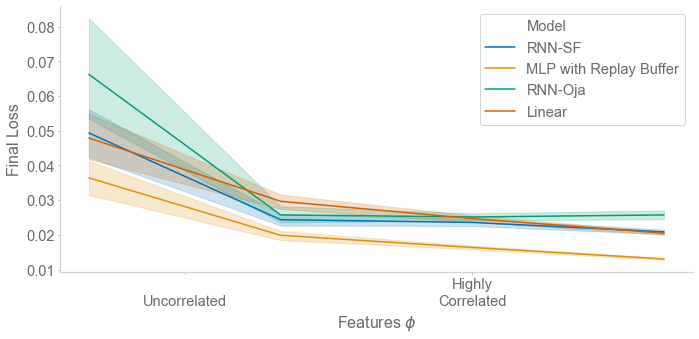

In [75]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(
    x='Sigma', y='Final Loss', hue='Model',
    ax = ax, data=df[(df['Gamma']==0.75)],
    hue_order=hue_order
    )
plt.xticks([0.5, np.unique(sigmas).size-2], ['\nUncorrelated', 'Highly\nCorrelated'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_corrlineplot.png', dpi=300)

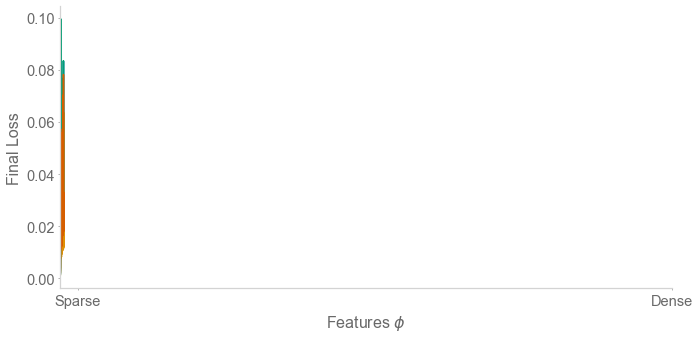

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(
    x='Sparsity', y='Final Loss', hue='Model',
    ax = ax, data=df[df['Gamma']==0.75],
    hue_order=hue_order, legend=None
    )
plt.xticks([1, np.unique(init_sparsities).size-2], ['Sparse', 'Dense'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_sparselineplot.png', dpi=300)

# Make 2D plots

In [76]:
np.unique(models)

array(['Linear', 'MLP with Replay Buffer', 'RNN-Oja', 'RNN-SF'],
      dtype='<U22')

In [77]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [78]:
def make_gradients(
    xs, ys, zs, models, cmap="Reds", interpolate=False,
    title=None, xlabel=None, ylabel=None, figname=None,
    smooth=False, contourz=None, figsize=[6.4, 4.8],
    plottype='RNN-SF', chance_relative=False, chance_zs=None
    ):
    
    xs = xs.astype(float)
    ys = ys.astype(float)
    zs = zs.astype(float)
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            ij_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models==plottype
                )
            _val = np.nanmean(zs[ij_idx])
            if chance_relative:
                _chance_val = np.nanmean(chance_zs[ij_idx])
                val = _chance_val/_val
            else:
                val = _val
            z[i,j] = val

    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots()
    if plottype == 'relative' or plottype=='chance_diff':
        im = ax.pcolormesh(
            x, y, z,
            cmap=plt.cm.seismic, vmin=1-(np.abs(z).max()-1), vmax=1+(np.abs(z).max()-1)
            )
    else:
        im = ax.pcolormesh(
            x, y, z
            )
    fig.colorbar(im, ax=ax)
    ax.set_title('pcolormesh with levels')
    plt.show()
    
    plt.figure()
    plt.imshow(z)
    plt.colorbar()
    plt.show()
            
    if interpolate:
        nan_mask = np.isnan(z)
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals
        
    if smooth:
        from scipy.ndimage.filters import gaussian_filter
        z = gaussian_filter(z, 1.)
        
    #levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    
    # contours are *point* based plots, so convert our bound into point
    # centers
    fig, ax = plt.subplots(figsize=figsize)
    if plottype == 'relative' or plottype == 'chance_diff':
        cf = ax.contourf(x,#[:-1, :-1] + dx/2.,
                         y,#[:-1, :-1] + dy/2.,
                         z, levels=levels,
                         cmap=plt.cm.seismic, vmin=1-(np.abs(z).max()-1), vmax=1+(np.abs(z).max()-1)
                         )
    else:
        cf = ax.contourf(x,#[:-1, :-1] + dx/2.,
                         y,#[:-1, :-1] + dy/2.,
                         z, levels=levels
                         )
    if contourz is not None:
        cntrs = plt.contour(
            x, y, contourz, [1.0],
            colors='dimgray'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


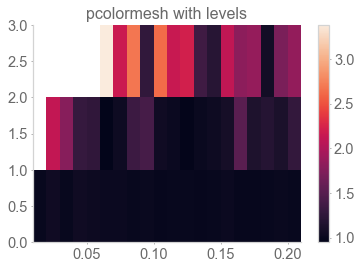

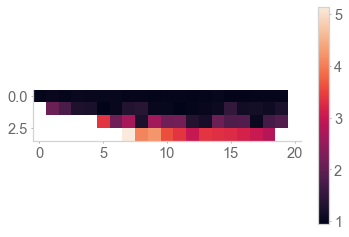

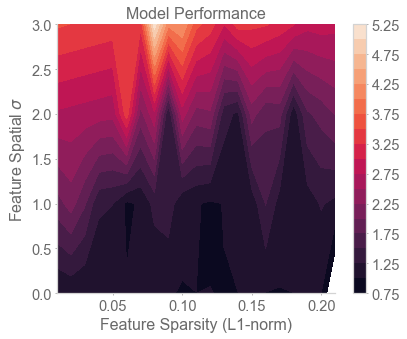

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


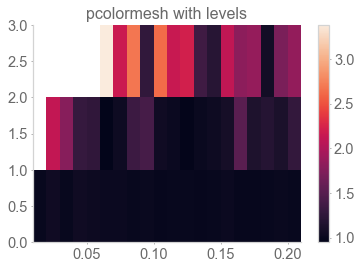

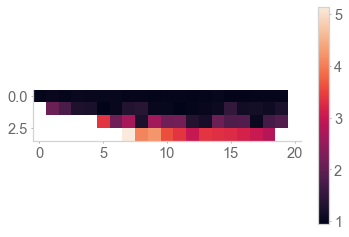

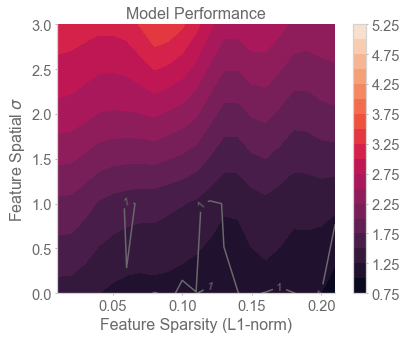

In [90]:
# RNN-SF
_gamma = 0.75
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5],
    plottype='RNN-SF', chance_relative=True,
    chance_zs = _chance_losses
    )

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    contourz=_z, plottype='RNN-SF', chance_relative=True,
    chance_zs = _chance_losses
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


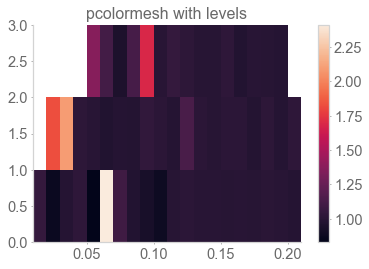

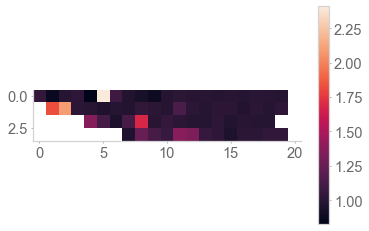

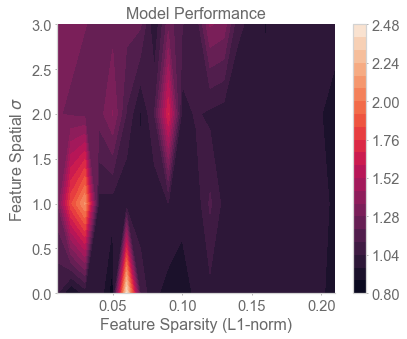

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


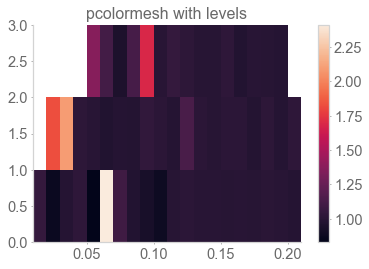

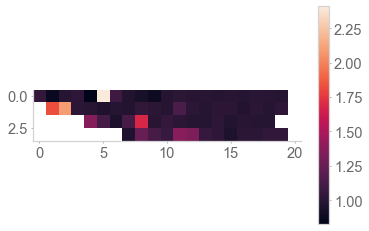

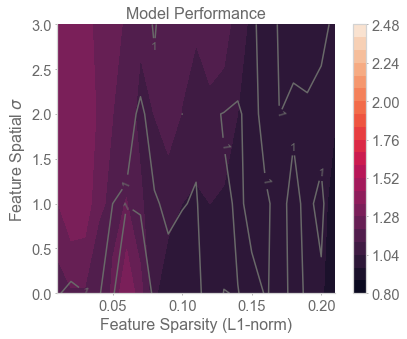

In [80]:
# RNN-Oja
_gamma = 0.75
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5],
    plottype='RNN-Oja', chance_relative=True,
    chance_zs = _chance_losses
    )

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    contourz=_z, plottype='RNN-Oja', chance_relative=True,
    chance_zs = _chance_losses
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


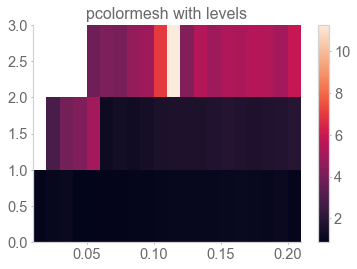

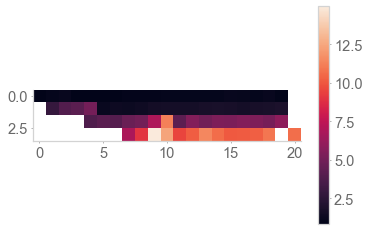

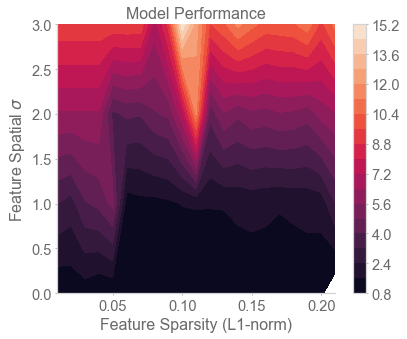

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


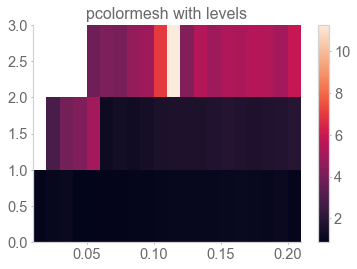

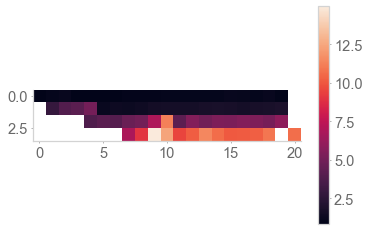

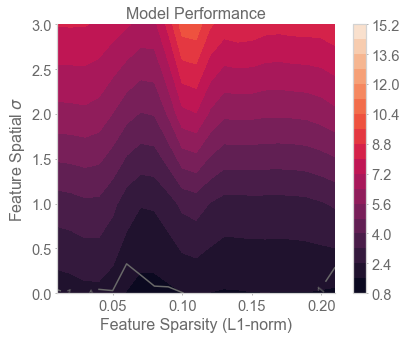

In [81]:
# Linear
_gamma = 0.75
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5],
    plottype='Linear', chance_relative=True,
    chance_zs = _chance_losses
    )

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    contourz=_z, plottype='Linear', chance_relative=True,
    chance_zs = _chance_losses
    )

In [82]:
x = final_losses[np.logical_and(
np.logical_and(
    init_sparsities=='0.012206896551724133',
    sigmas=='2.5'),
np.logical_and(
    gammas==0.75,
    models=='RNN-SF Chance')
)]
print(x)
print(np.mean(x))

[]
nan


/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
x = final_losses[np.logical_and(
np.logical_and(
    init_sparsities=='0.012206896551724133',
    sigmas=='2.5'),
np.logical_and(
    gammas==0.75,
    models=='RNN-Oja')
)]
print(x)
print(np.mean(x))

[]
nan


In [27]:
x = final_losses[np.logical_and(
np.logical_and(
    init_sparsities=='0.012206896551724133',
    sigmas=='2.5'),
np.logical_and(
    gammas==0.75,
    models=='RNN-SF')
)]
print(x)
print(np.mean(x))

[]
nan


In [28]:
x = final_losses[np.logical_and(
np.logical_and(
    init_sparsities=='0.012206896551724133',
    sigmas=='2.5'),
np.logical_and(
    gammas==0.75,
    models=='Linear')
)]
print(x)
print(np.mean(x))

[]
nan


# Testing

In [18]:
from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP, Hopfield
from run_td_rnn import run as run_rnn

sparsity_p = 0.007103448275862068
spatial_sigma = 1.25
num_states = input_size = 20*20
num_steps = 2000
dataset = sf_inputs_discrete.Sim2DWalk
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_type': 'correlated_distributed',
    'feature_vals_p': [1-sparsity_p, sparsity_p],
    'spatial_sigma': spatial_sigma
    }
dataset_config = {
    'num_steps': num_steps, 'feature_maker_kwargs': feature_maker_kwargs,
    'num_states': num_states
    }

net = AnalyticSR(
    num_states=input_size, gamma=0.6,
    ca3_kwargs={
        'use_dynamic_lr':False, #'lr': -0.02046,
        'output_params':{
            'num_iterations':25, 'nonlinearity': 'clamp',
            #'nonlinearity_args': [-0.055744, 2.045]
            }, 'parameterize': True
        }
    )
_, _, _, net = run_rnn(
    'test/', net, dataset, dataset_config,
    gamma=0.6,
    train_net=True, test_over_all=False
    )

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=146055, Sat Jan  1 15:18:10 2022)


KeyboardInterrupt: 

In [ ]:
netT = AnalyticSR(
    num_states=input_size, gamma=0.6,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 0.1,
        'output_params':{
            'num_iterations':25, 'nonlinearity': 'sigmoid',
            #'nonlinearity_args': [-0.055744, 2.045]
            }, 'parameterize': False
        }
    )
netT.ca3.sigmoid_a.fill_(0.9758)
netT.ca3.sigmoid_b.fill_(-2.0594)
netT.ca3.parameterize = True

In [ ]:
dataset_config = {
    'num_steps': 6000, 'feature_maker_kwargs': feature_maker_kwargs,
    'num_states': num_states
    }

out, loss, dset, _net = run_rnn(
    'test/', netT, dataset, dataset_config,
    gamma=0.6,
    train_net=False, test_over_all=False
    )

In [ ]:
from utils import get_firing_field
from scipy import ndimage
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(out.shape[1])
np.random.shuffle(neurs)
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(dset.num_states))

idx = 0
for neur in neurs:
    ff, _ = get_firing_field(
        walk_xs, walk_ys, out[:,neur],
        arena_length, normalize=True
        )
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(ff/ff.max(), vmin=0., vmax=1, cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])

    idx += 1
    if idx == grid_x*grid_y: break
plt.show()